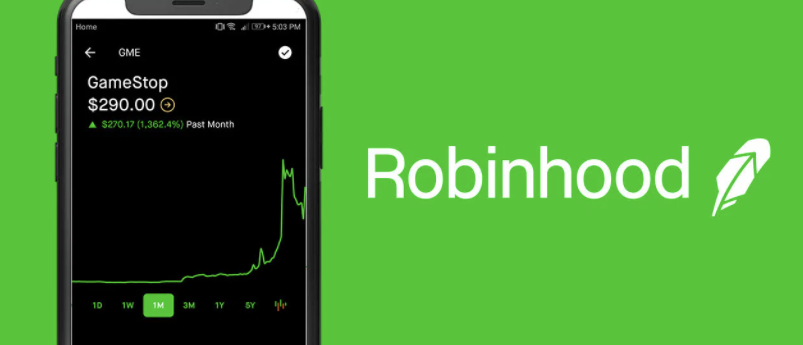

### Robinhood Collapse Summary
* Robinhood said their clearinghouse needed additional capital to fund the overwhelming amount of meme stocks in it's portfolio.


* [Here is the video](https://www.youtube.com/watch?v=aicDIMtVld8&list=WL&index=4&t=1346s) of Vlad Tenev (CEO of Robinhood) talking with Elon Musk (CEO of Tesla) about the cause for the hault of buying more meme stocks.
    * Main takeaway. Vlad said NSCC (clearing house is NSCC) required more funds. Started with 3B requirement, moved to 1.4B, and eventually settled on 700M which Robinhood could pay. This was only once they haulted the buying of more meme stocks, but could allow the liquidation (closing) of the stocks.


* Who dictates how much money a broker owes to its clearing house?
    * [Here is a link](https://www.sec.gov/rules/sro/nscc-an/2018/34-82631.pdf) to the SEC's Proposal for Enhance the Calculation of the Volatility Component of the Clearing Fund Formula that Utilizes a Parametric Value-at-Risk Model.
    


* [Python Article for VaR Calculations](https://www.interviewqs.com/blog/value-at-risk)

### Assumptions
* I'm using the Variance-Covariance Method to Calculate VaR.
    * Based on the SEC guidelines, they seem to be using an exponential-weighting, meaning the VaR will be more drastic for more recent returns.
* I'm making weighting assumptions of [.15, .15, .40, .30], for SPY, AAPL, GME, and AMC.
* I'm assuming Robinhood has 2B dollars USD. ~13M users would mean about $153 per account.

In [73]:
# Set the investment weights for AAPL, GME, AMC
weights = np.array([.15, .15, .40, .30])

# Set an initial investment level
initial_investment = 2000000000

In [68]:
import pandas as pd
import numpy as np

# Read in equities data
df = pd.read_csv("RobinhoodCollapse.csv", index_col=0)
print("Prices of meme stocks:")
display(df.tail(3))

# Map SIDS to Tickers
df_map = pd.read_csv("meme_sid_mapping.csv")
df_map = df_map[['Sid', "Symbol"]]
# display(df_map.tail())
new_cols = []
for row in df_map.iterrows():
    for col in df.columns:
        if str(row[1]['Sid'])==str(col):
            new_cols.append(col+f"_({row[1]['Symbol']})")
df.columns = new_cols
 
#From the closing prices, calculate periodic returns
returns = df.pct_change()
print("Returns of meme stocks:")
returns.tail(3)

Prices of meme stocks:


,FIBBG000B9XRY4,FIBBG000BB5BF6,FIBBG000BDTBL9,FIBBG000TDCVT6
Date,,,,
2021-01-27,142.06,347.51,374.41,19.90
2021-01-28,137.09,193.60,377.63,8.63
2021-01-29,131.96,325.00,370.07,13.26


Returns of meme stocks:


,FIBBG000B9XRY4_(AAPL),FIBBG000BB5BF6_(GME),FIBBG000BDTBL9_(SPY),FIBBG000TDCVT6_(AMC)
Date,,,,
2021-01-27,-0.007684,1.348358,-0.02444,3.012097
2021-01-28,-0.034985,-0.442894,0.00860,-0.566332
2021-01-29,-0.037421,0.678719,-0.02002,0.536501


### Calculate Covariance Matrix

In [69]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()
cov_matrix

,FIBBG000B9XRY4_(AAPL),FIBBG000BB5BF6_(GME),FIBBG000BDTBL9_(SPY),FIBBG000TDCVT6_(AMC)
FIBBG000B9XRY4_(AAPL),0.000581,-0.000355,0.000118,-0.001164
FIBBG000BB5BF6_(GME),-0.000355,0.180017,-0.003088,0.234096
FIBBG000BDTBL9_(SPY),0.000118,-0.003088,0.000106,-0.005189
FIBBG000TDCVT6_(AMC),-0.001164,0.234096,-0.005189,0.530896


### Calculate the portfolio mean and standard deviation

In [70]:
# Calculate mean returns for each stock
avg_rets = returns.mean()

# Calculate mean returns for portfolio overall, 
# using dot product to 
# normalize individual means against investment weights
 # https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.
port_mean = avg_rets.dot(weights)
 
# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
 
# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment
             
# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

### Calculate VaR

In [74]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
# as calculated above
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
print(f"${var_1d1:,.2f}")

$672,908,008.40


### VaR by day

1 day VaR @ 95% confidence: $672,908,008.40
2 day VaR @ 95% confidence: $951,635,631.70
3 day VaR @ 95% confidence: $1,165,510,859.36
4 day VaR @ 95% confidence: $1,345,816,016.79
5 day VaR @ 95% confidence: $1,504,668,049.38
6 day VaR @ 95% confidence: $1,648,281,264.40
7 day VaR @ 95% confidence: $1,780,347,245.44
8 day VaR @ 95% confidence: $1,903,271,263.40
9 day VaR @ 95% confidence: $2,018,724,025.19
10 day VaR @ 95% confidence: $2,127,921,962.30
11 day VaR @ 95% confidence: $2,231,783,382.27
12 day VaR @ 95% confidence: $2,331,021,718.72
13 day VaR @ 95% confidence: $2,426,204,327.94
14 day VaR @ 95% confidence: $2,517,791,220.23
15 day VaR @ 95% confidence: $2,606,161,510.04


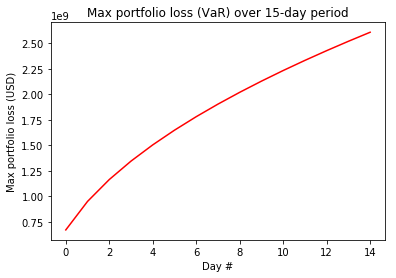

In [75]:
import matplotlib.pyplot as plt

# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + f"${np.round(var_1d1 * np.sqrt(x),2):,.2f}")

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")
plt.show()